## Putting All together

In [173]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [174]:
print("Torch version" , torch.__version__)

Torch version 2.5.1+cpu


## Device agnostic code

`if code get's access to gpu code will uses the GPU else CPU`

In [175]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [176]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [177]:
from sklearn.datasets import make_regression

X,y = make_regression(n_samples=50, n_features=1, n_targets=1,bias=5, noise=10, random_state=42) 
# y = w0 + w1 * x
X.shape, y.shape

((50, 1), (50,))

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((35, 1), (35,))

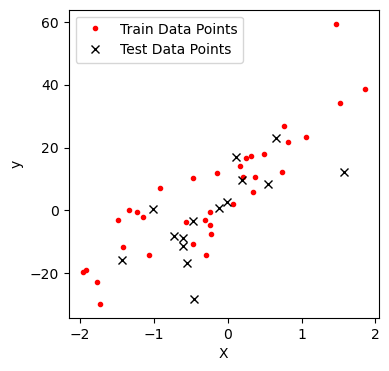

In [179]:
plt.figure(figsize=(4,4))
plt.plot(X_train, y_train, "r.", label="Train Data Points")
plt.plot(X_test, y_test, "kx", label="Test Data Points")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


## Predictions using sklearn

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)
y_pred = model_sklearn.predict(X_test)
print("R2 Score ::",r2_score(y_test, y_pred))
w0 = model_sklearn.intercept_
w1 = model_sklearn.coef_

R2 Score :: 0.2113757821097052


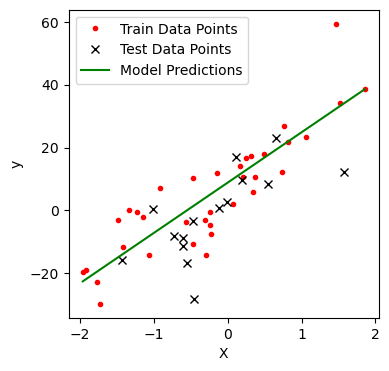

In [181]:
w0 = torch.tensor(model_sklearn.intercept_, dtype=torch.float32)
w1 = torch.tensor(model_sklearn.coef_, dtype=torch.float32)

# Ensure X_train is a Torch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Generate points for plotting or further computation
X_point = torch.linspace(X_train_tensor.min().item(), X_train_tensor.max().item(), steps=100)

# Compute corresponding y values
y_point = w0 + w1 * X_point

plt.figure(figsize=(4,4))
plt.plot(X_train, y_train, "r.", label="Train Data Points")
plt.plot(X_test, y_test, "kx", label="Test Data Points")
plt.plot(X_point, y_point, "g-", label="Model Predictions")

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# X_point # tensor


## Prediction using pytorch

`1 ) turn data into tensors using *torch.tensor(data)* `

In [182]:
# since X_train, y_train and X_test, y_test having the type is numpy.ndarray so we need to convert it into the tensor values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(type(y_test_tensor), type(y_test))


<class 'torch.Tensor'> <class 'numpy.ndarray'>


In [183]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([35, 1]), torch.Size([35]))

`2) Build Pytorch linear model`

In [184]:
#  create a linear model by subclass nn.module
# nn contains many layer like (convolution layer , pooling layer, linear l;ayer) ...
class LinearRegressionPytorch(nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        # use linear layer instead of parameter defined by ourseleves (nn.Linear)
        # linear layer also called linear tranform, probing layer, fully connected layer , dense layer
        self.linear_layer = nn.Linear(in_features=in_feature, out_features=out_feature)
        # y = x.(A.T) + b behind the scenes parameter created automatically for our selves

    def forward(self, x) :
        return self.linear_layer(x)


In [185]:
model_test = LinearRegressionPytorch(6,3)
print("Weight", model_test.linear_layer.weight, model_test.linear_layer.weight.shape)
print("Bias", model_test.linear_layer.bias, model_test.linear_layer.bias.shape)
print("All", model_test.state_dict())

Weight Parameter containing:
tensor([[ 0.3121,  0.3388, -0.0956,  0.3750, -0.0894,  0.0824],
        [-0.1988,  0.2398,  0.3599, -0.2995,  0.3548,  0.0764],
        [ 0.3016,  0.0553,  0.1969, -0.0576,  0.3147,  0.0603]],
       requires_grad=True) torch.Size([3, 6])
Bias Parameter containing:
tensor([-0.1906,  0.1041, -0.1881], requires_grad=True) torch.Size([3])
All OrderedDict({'linear_layer.weight': tensor([[ 0.3121,  0.3388, -0.0956,  0.3750, -0.0894,  0.0824],
        [-0.1988,  0.2398,  0.3599, -0.2995,  0.3548,  0.0764],
        [ 0.3016,  0.0553,  0.1969, -0.0576,  0.3147,  0.0603]]), 'linear_layer.bias': tensor([-0.1906,  0.1041, -0.1881])})


In [186]:
torch.manual_seed(42)
# trying linear layer 
model_pytorch = LinearRegressionPytorch(1,1)
model_pytorch.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

`Checking the device for the cuda`

In [187]:
# check the model cuurent device 
next(model_pytorch.parameters()).device
# covert the cpu to cuda 
model_pytorch.to(device)
# checking the device again
next(model_pytorch.parameters()).device

device(type='cpu')

`Training Pytorch Linear Model (Linear Layer)`
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

In [188]:
# setuip loss function
los_fn = nn.L1Loss()
# define the optimizer
optimizer = torch.optim.SGD(params=model_pytorch.parameters(), lr = 0.2)

In [189]:
#  lets write the training loops
# print(X_train_tensor.shape, y_train_tensor.shape)
torch.manual_seed(42)
epochs = 3000

X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

for epoch in range(epochs):
    # print("run")
    model_pytorch.train()
    # forward pass
    y_pred = model_pytorch(X_train_tensor)
    #loss value
    loss = los_fn(y_pred, y_train_tensor.reshape(-1,1))
    # optiimizer
    optimizer.zero_grad()
    # perform backpropagation
    loss.backward()
    # optimier step
    optimizer.step()

    ## Testing loop evaluation mode
    if(epoch+1) % 500 == 0:
        model_pytorch.eval()
        with torch.inference_mode():
            y_pred_test = model_pytorch(X_test_tensor)
            print(f"epoch {epoch + 1} / {epochs}")
            print("Loss for Test Dataset ::", los_fn(y_pred_test, y_test_tensor.reshape(-1,1)).item())


epoch 500 / 3000
Loss for Test Dataset :: 9.896056175231934
epoch 1000 / 3000
Loss for Test Dataset :: 9.90800952911377
epoch 1500 / 3000
Loss for Test Dataset :: 9.919964790344238
epoch 2000 / 3000
Loss for Test Dataset :: 9.922502517700195
epoch 2500 / 3000
Loss for Test Dataset :: 9.921978950500488
epoch 3000 / 3000
Loss for Test Dataset :: 9.92236042022705


In [190]:
parameter_dict = dict(model_pytorch.state_dict())
parameter_dict

{'linear_layer.weight': tensor([[14.8882]]),
 'linear_layer.bias': tensor([9.4700])}

X_point shape: torch.Size([100]), y_pytorch shape: torch.Size([100])


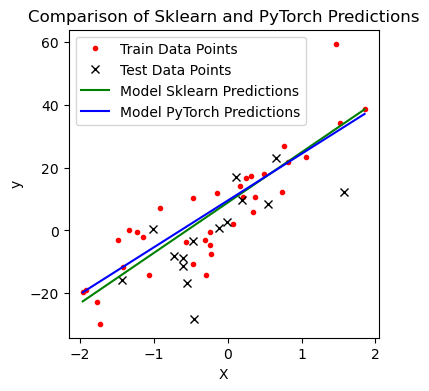

In [191]:
import matplotlib.pyplot as plt
import torch

# Assuming model_sklearn and model_0 (PyTorch model) are already trained
parameter_dict = model_pytorch.state_dict()

# Extract weights and bias from sklearn and PyTorch models
w0 = torch.tensor(model_sklearn.intercept_, dtype=torch.float32)
w1 = torch.tensor(model_sklearn.coef_, dtype=torch.float32)

w1_tensor = parameter_dict['linear_layer.weight'].squeeze()  # Squeeze to make it 1D
w0_tensor = parameter_dict['linear_layer.bias']

# Ensure X_train is a Torch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Generate points for plotting or further computation
X_point = torch.linspace(X_train_tensor.min().item(), X_train_tensor.max().item(), steps=100)

# Compute corresponding y values
y_point = w0 + w1 * X_point  # Sklearn predictions
y_pytorch = w0_tensor + w1_tensor * X_point  # PyTorch predictions

# Verify shapes
print(f"X_point shape: {X_point.shape}, y_pytorch shape: {y_pytorch.shape}")

# Plot the results
plt.figure(figsize=(4, 4))
plt.plot(X_train, y_train, "r.", label="Train Data Points")
plt.plot(X_test, y_test, "kx", label="Test Data Points")
plt.plot(X_point, y_point, "g-", label="Model Sklearn Predictions")
plt.plot(X_point, y_pytorch, "b-", label="Model PyTorch Predictions")  # Changed to "b-" for distinction

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of Sklearn and PyTorch Predictions")
plt.show()


## Saving and Training Model

In [192]:
from pathlib import Path

# create a model directory
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

# create model save path
model_name = "02_pytorch_linear_regression_model.pth"
model_save_name = model_path/model_name

## save the model of state dict
torch.save(obj = model_pytorch.state_dict(), f=model_save_name)

## Load Pytorch model

In [193]:
# # create a new instance of libear regression model

# loaded_model = LinearRegressionPytorch()

# loaded_model.load_state_dict(torch.load(model_save_name))

# loaded_model.to(device)